# Introduction
This notebook documents the set up of a RNN model designed to translate sign language into natural language using sensor data our "magic" gloves. The gloves are equipped with flexion sensors, accelerometers, and gyroscopes, providing a rich dataset for analysis. Our objective is to create a model that accurately interprets sign language based on our dataset, paving the way for improved communication and accessibility.

# Import Libraries
The following libraries are essential for data processing, model building, and evaluation:
- Numpy and Pandas for data handling.
- Scikit-learn for data preprocessing and model evaluation.
- Keras for building and training the Recurrent Neural Network (RNN) model.


In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Bidirectional, BatchNormalization
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import plot_model

# Data Loading, Inspection and Cleaning
## Data Loading and Concatenation
In this section, we load sensor data from multiple CSV files. Each file represents data from different individuals, and we concatenate these into a single DataFrame for comprehensive analysis.


In [84]:
df_1 = pd.read_csv('../dataset/sensor_data_badr.csv')
df_2 = pd.read_csv('../dataset/sensor_data_mouad.csv')
df_3 = pd.read_csv('../dataset/sensor_data_ismail.csv')
# Concatenate the three dataframes
df = pd.concat([df_1, df_2, df_3], ignore_index=True)

## Data Inspection
First, we inspect the dataset's size and structure to understand its dimensions and scope.



In [85]:
# number of rows and columns
print(df.shape)

(1791, 441)


## Data Cleaning
We then convert feature columns to numeric values, handling non-convertible values by setting them to NaN. This is followed by removing rows with NaN values, ensuring data quality and consistency.

In [86]:
# Convert all feature columns to numeric and set non-convertible values to NaN
for col in df.columns[:-1]:  # Excluding the last column
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [87]:
# Removing rows with NaN values
df.dropna(inplace=True)

# Data Preprocessing
## Feature and Label Separation
Separating features and labels is a crucial step in preparing the dataset for the model.

In [88]:
# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last one
y = df.iloc[:, -1].values   # Only the last column

## Feature Scaling
We use MinMaxScaler to normalize feature values, ensuring consistent input scale for the RNN model.

In [89]:
# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Data Reshaping for RNN
The data is reshaped to fit the RNN's input requirements, adjusting its structure to (samples, time steps, features).


In [90]:
# Reshape X to fit the RNN model (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

## Label Encoding and Dictionary Creation
Labels are encoded using one-hot encoding for multi-class classification. We also create a dictionary mapping encoded labels to their meanings, enhancing interpretability.

In [91]:
# Encode the labels
encoder = OneHotEncoder(sparse=False)
# create dictionary of encoded labels and their meanings
y_encoded = encoder.fit_transform(y.reshape(-1, 1))
labels_dict = {i: label for i, label in enumerate(encoder.categories_[0])}
print(labels_dict)

{0: 'PROUD', 1: 'STUDENT', 2: 'THANK YOU', 3: 'THIS', 4: 'WE', 5: 'WORK'}


c:\Users\lenovo\Desktop\ENSIMAG\IA & IoT\magic-gloves\magic-gloves-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [92]:
print(y_encoded)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


# Model Building and Compilation
Here, we define the RNN model's architecture, adding necessary layers like Bidirectional SimpleRNN, BatchNormalization, and Dense layers. The model is then compiled with an optimizer and loss function suited for our multi-class classification task.


In [93]:
# Define the RNN model
model_rnn = Sequential()
model_rnn.add(Bidirectional(SimpleRNN(30, activation='relu', return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model_rnn.add(BatchNormalization())
model_rnn.add(SimpleRNN(32, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(16, activation='relu'))
model_rnn.add(Dense(y_encoded.shape[1], activation='softmax'))

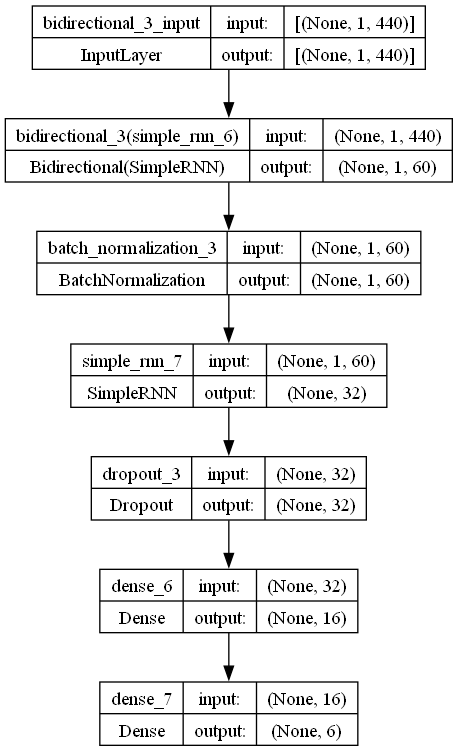

In [94]:
# Plot the model architecture to an image file
plot_model(model_rnn, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)


In [95]:
# Compile the model with categorical_crossentropy loss function
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [96]:
# Add EarlyStopping as a callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model Training
We split the dataset into training and testing sets to evaluate the model's performance on unseen data. The model is trained using the fit method, with validation on the test set and EarlyStopping callback to prevent overfitting.


In [97]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [98]:
# Train the model
history = model_rnn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100


45/45 [==============================] - 3s 12ms/step - loss: 1.1776 - accuracy: 0.5412 - val_loss: 1.2993 - val_accuracy: 0.4190
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.4769 - accuracy: 0.8966 - val_loss: 0.6888 - val_accuracy: 0.7179
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9832 - val_loss: 0.2979 - val_accuracy: 0.9106
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0839 - accuracy: 0.9902 - val_loss: 0.0651 - val_accuracy: 0.9972
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0504 - accuracy: 0.9944 - val_loss: 0.0233 - val_accuracy: 0.9972
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0390 - accuracy: 0.9958 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0288 - accuracy: 0.9958 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 8/100
45/45 [=====

# Model Saving and Evaluation
## Model Saving
After training, we save the model and scaler for future use in real-world applications or further analysis.


In [99]:
# Save the model
model_rnn.save('rnn_model.h5')
# Save the scaler to use it in predict.py and scale the realtime data
joblib.dump(scaler, 'rnn_scaler.joblib')

c:\Users\lenovo\Desktop\ENSIMAG\IA & IoT\magic-gloves\magic-gloves-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['rnn_scaler.joblib']


## Model Evaluation
The model's performance is evaluated using key metrics such as accuracy, precision, recall, and F1-score on the test set. A confusion matrix is also generated to visualize the model's performance and understand its error types.


In [100]:
# Access the loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [101]:
# Make predictions on the test set
y_pred = model_rnn.predict(X_test)

12/12 [==============================] - 0s 1ms/step


In [102]:
# Convert predictions to classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [103]:
# Calculate the accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy on the test set: 100.00%
Precision: 1.00
Recall: 1.00
F1-score: 1.00


In [104]:
# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[58  0  0  0  0  0]
 [ 0 64  0  0  0  0]
 [ 0  0 53  0  0  0]
 [ 0  0  0 62  0  0]
 [ 0  0  0  0 51  0]
 [ 0  0  0  0  0 70]]


# Results Visualization
Visualizing training and validation loss and accuracy helps diagnose model issues (like overfitting or underfitting) and understand its learning behavior over epochs.


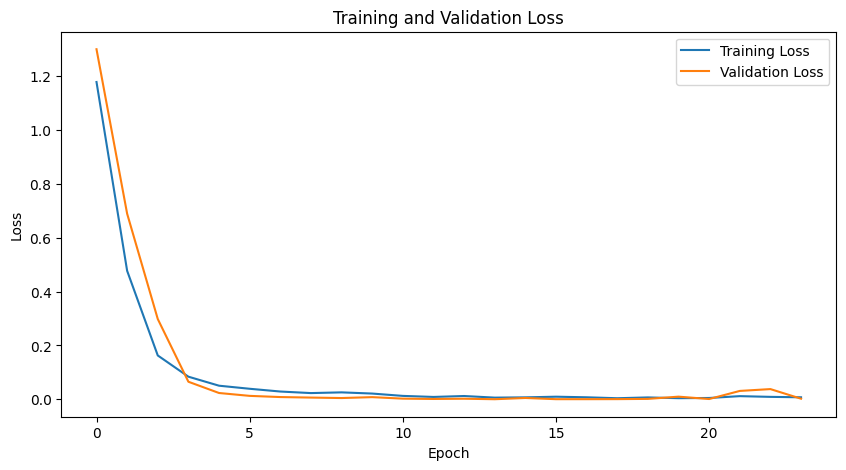

In [105]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

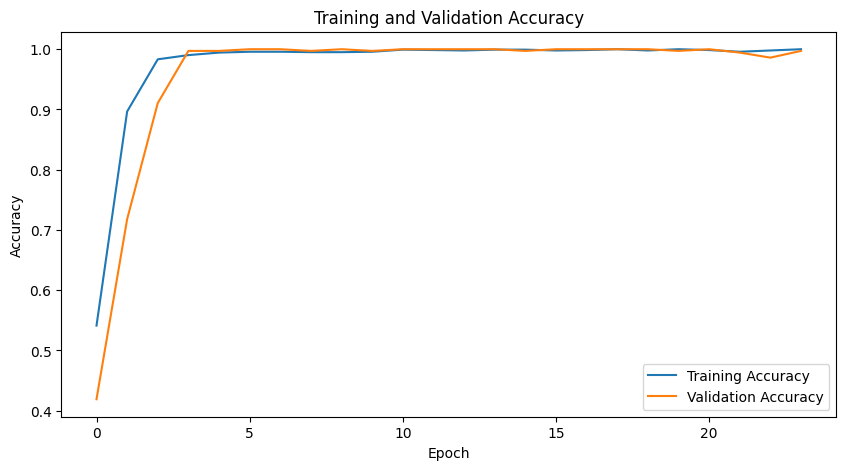

In [106]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Conclusion
The model demonstrates a notably high accuracy, which, while encouraging, warrants a closer examination.

The exceptionally high accuracy achieved might be indicative of certain underlying factors such as overfitting, or the distinct nature of the signs. These possibilities highlight the need for rigorous validation techniques and potentially expanding our dataset to include more varied samples.

Additionally, the reduced and specific nature of our dataset could have contributed to the high accuracy. Our model might be recognizing patterns unique to this dataset that may not generalize well to broader, more diverse sign language data.

In conclusion, while the results are promising, they invite further investigation and validation. Future work will focus on addressing these potential issues.

